# Using Citation Bias to Guide Better Sampling of Scientific Literatures

Author: Yuanxi Fu, Jasmine Yuan<br>
Date: 2021-1-26<br>
Code for the paper submitted to ISSI 2021

## load data

In [1]:
import pandas as pd
from igraph import *
import cairo
import numpy as np
import math
from matplotlib import pyplot as plt

# create attribute list
# easy for this file because the first 6 columns are in fact attribute list
attr_list = pd.read_csv('HTTLPR.csv', usecols=[0, 1, 2, 3, 4, 5])
attr_list['PaperID'] = attr_list.index

# create edge list
matrix = pd.read_csv('HTTLPR.csv')


In [2]:
matrix

,Study,Year,YearOnline,Outcome,OutcomeSmallestPvalue,Abstract,Mossner,Caspi,Eley,Grabe_a,...,Comasco_a,Cicchetti_b,Jenness,Scheid_b,Quinn,Grabe_b,Petersen,Beaver,Brown,Wilhelm_b
0,Mossner,2001,2001,Positive,Positive,Positive,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Caspi,2003,2003,Positive,Positive,Positive,-,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Eley,2004,2004,Negative,Negative,Positive,-,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grabe_a,2005,2004,Unclear,Unclear,Partially supportive,-,X,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kaufman_a,2004,2004,Positive,Positive,Positive,-,X,-,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Grabe_b,2012,2012,Negative,Negative,Partially supportive,-,X,-,X,...,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN
69,Petersen,2012,2012,Positive,Positive,Positive,-,X,X,-,...,-,-,-,-,-,-,NaN,NaN,NaN,NaN
70,Beaver,2012,2012,Positive,Positive,Partially supportive,-,X,-,-,...,-,-,-,-,-,-,-,NaN,NaN,NaN
71,Brown,2013,2012,Negative,Positive,Positive,-,X,X,-,...,-,-,-,-,-,-,-,-,NaN,NaN


In [2]:
# select only the adjacency matrix
matrix = matrix.iloc[:, 6:]

# search_for_alias
search_dict = pd.Series(attr_list['PaperID'].values, index=attr_list['Study']).to_dict()
search_dict_reverse = pd.Series(attr_list['Study'].values, index=attr_list['PaperID']).to_dict()
matrix.columns = [search_dict[x] for x in matrix.columns]

## Reconstruct claim-specific citation network g

In [3]:
# initialize the graph object
g = Graph(directed=True)
g.add_vertices(73)

# add attributes to the graph: study name: name; study outcome: outcome; YearOnline: year
study = attr_list['Study'].to_list()
outcome = attr_list['Outcome'].to_list()
g.vs['name'] = study
g.vs["label"] = g.vs["name"]
g.vs['outcome'] = outcome
g.vs['year'] = attr_list['YearOnline']
g.vs['color'] = 'light blue'

# create edges for the real graph, using the matrix
edge_list = []
for i in range(0, matrix.shape[0]):
    for j in range(0, matrix.shape[1]):
        if isinstance(matrix.iloc[i, j], str):
            s = matrix.iloc[i, j]
            if s.replace(" ", "") == "X":
                edge_list.append((i, j))
                g.add_edge(source=i, target=j)

### Verify the reconstruction by calculating average citations (reported in the Vries et al., 2016)

In [4]:
positive_nodes = g.vs.select(outcome='Positive')
negative_nodes = g.vs.select(outcome='Negative')
neutral_nodes = g.vs.select(outcome='Unclear')

n1 = mean(g.degree(vertices=positive_nodes,mode=IN))
n2 = mean(g.degree(vertices=negative_nodes,mode=IN))
n3 = mean(g.degree(vertices=neutral_nodes,mode=IN))

print('Average citation for positive articles is', str(round(n1,1)))
print('Average citation for negative articles is', str(round(n2,1)))
print('Average citation for neutral articles is', str(round(n3,1)))

Average citation for positive articles is 9.8
Average citation for negative articles is 5.4
Average citation for neutral articles is 4.3


## Visualize the network

In [5]:
vis = plot(g,layout="kk", margin=50,bbox=(600,600))
vis.show()

## Create the simulated network
Allow a directional edge from node2 to node1 if node2['year'] - node1['year'] >= year_gap

In [6]:
year_gap = 2

# initialize simulated network g_sim
g_sim = Graph(directed=True)
g_sim.add_vertices(73)
g_sim.vs['name'] = study
g_sim.vs["label"] = g_sim.vs["name"]
g_sim.vs['outcome'] = outcome
g_sim.vs["color"] = 'light blue'
g_sim.vs['Year'] = attr_list['YearOnline']

sim_edge_list = []

# construct graph
for i in g_sim.vs.indices:
    for j in g_sim.vs.indices:
        if g_sim.vs[j]['Year'] - g_sim.vs[i]['Year'] >= year_gap:
            g_sim.add_edge(j, i)

In [7]:
len(g_sim.es) # number of edges

1799

In [7]:
vis_sim = plot(g_sim,layout="kk", margin=50,bbox=(600,600))
vis_sim.show()

## Calculating metric 1: the ratio between real and theoretical citations

In [8]:
g_degree = pd.Series(data=g.degree(mode=IN),index=g.vs.indices)

In [13]:
g_degree

0      5
1     65
2     37
3     21
4     27
      ..
68     0
69     0
70     0
71     0
72     0
Length: 73, dtype: int64

In [15]:
g_sim_degree = pd.Series(data=g_sim.degree(mode=IN),index=g_sim.vs.indices)

In [16]:
g_sim_degree

0     72
1     67
2     63
3     63
4     63
      ..
68     0
69     0
70     0
71     0
72     0
Length: 73, dtype: int64

In [17]:
degree_ratio = pd.DataFrame(columns=['paperID','degree_ratio'])

last_generation = []

for idx, degree in enumerate(g_degree):
    if g_sim_degree[idx]!=0:
        degree_ratio = degree_ratio.append({'paperID': idx, 'degree_ratio': round(g_degree[idx] / g_sim_degree[idx],3)},
                            ignore_index=True)
    else:
        last_generation.append(idx) # not suppose to have citations because of the constructs

In [18]:
degree_ratio

,paperID,degree_ratio
0,0.0,0.069
1,1.0,0.970
2,2.0,0.587
3,3.0,0.333
4,4.0,0.429
5,5.0,0.508
6,6.0,0.618
7,7.0,0.455
8,8.0,0.327
9,9.0,0.109


### set cutoff for articles that are extremely insufficiently cited

In [11]:
low_cutoff = 0.1

### set cutoff for articles that are sufficiently cited

In [12]:
high_cutoff = 0.9

In [13]:
idx_low = degree_ratio[degree_ratio['degree_ratio'] < low_cutoff].index.tolist()
idx_low = [int(item) for item in idx_low]

idx_high = degree_ratio[degree_ratio['degree_ratio'] > high_cutoff].index.tolist()
idx_high = [int(item) for item in idx_high]

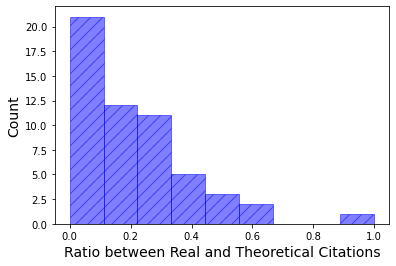

In [14]:
bins = np.linspace(0,1,10)
plt.hist(degree_ratio['degree_ratio'], bins=bins,color='blue', edgecolor='blue', linewidth=1, hatch="//",
         histtype='bar', alpha=0.5)
plt.xlabel('Ratio between Real and Theoretical Citations',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

### Select nodes by the value
Select nodes that either have the ratio smaller than 0.1 (extermely insufficiently cited) or greater than 0.9 (sufficiently cited)

In [15]:
for node in g.vs.indices:
    if node in idx_low:
        g.vs[node]['citation_ratio'] = 'Low'
    elif node in idx_high:
        g.vs[node]['citation_ratio'] = 'High'
    elif node in last_generation:
        g.vs[node]['citation_ratio'] = 'Last Generation'
    else:
        g.vs[node]['citation_ratio'] = 'Average'

# block of code for visualization [ update here ]
color_dict = {"High": "green", "Low": "pink", "Average": "light blue","Last Generation":"white"}
g.vs["color"] = [color_dict[ratio] for ratio in g.vs["citation_ratio"]]
plot(g,bbox=(600,600),margin=50,layout="kk").show()

### Print nodes that are extremely insufficiently cited

In [16]:
for node in idx_low:
    print(g.vs[node]['name'],g.vs[node]['year'],g.vs[node]['outcome'])

Mossner 2001 Positive
Dick 2007 Unclear
Kraus 2007 Negative
Kilpatrick 2007 Unclear
Bull 2008 Positive
Lotrich 2008 Unclear
Zhang_a 2008 Negative
PhillipsBute 2008 Negative
Zhang_b 2009 Negative
Kim_b 2009 Positive
Gibb 2009 Unclear
Coventry 2009 Negative
Grassi 2010 Negative
Sen 2010 Positive
Antypa 2010 Negative
Conway 2010 Negative


## Calculating metric 2: Relative evidence coupling strength

In [17]:
# initialize the data storage
coupling_strength = pd.DataFrame(columns=['node_1','node_2','ratio'])

# looping through each pair in the net
for node_1_ix in g.vs.indices:
    for node_2_ix in g.vs.indices:
        if node_2_ix > node_1_ix:
            node_1 = g.vs[node_1_ix]
            node_2 = g.vs[node_2_ix]
            node_1_set = set(g.neighbors(node_1, mode=OUT))
            node_2_set = set(g.neighbors(node_2, mode=OUT))
            node_1_set.intersection(node_2_set)
            if (len(node_1_set) + len(node_2_set)) != 0:
                strength = len(node_1_set.intersection(node_2_set)) / (
                        len(node_1_set) + len(node_2_set) - len(
                    node_1_set.intersection(node_2_set)))  # full is 1, no overlap is zero
                coupling_strength = coupling_strength.append({'node_1': node_1_ix,
                                         'node_2': node_2_ix,
                                         'ratio': strength},ignore_index=True)

In [18]:
coupling_strength.describe()

,node_1,node_2,ratio
count,2625.000000,2625.000000,2625.000000
mean,23.693333,48.373714,0.205428
std,17.079532,17.053520,0.195948
min,0.000000,2.000000,0.000000
25%,9.000000,36.000000,0.076923
50%,21.000000,51.000000,0.166667
75%,36.000000,63.000000,0.285714
max,71.000000,72.000000,1.000000


### Visualizing the distribution

(array([877., 806., 382., 275., 140.,  53.,  31.,   8.,  53.]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 <a list of 9 Patch objects>)

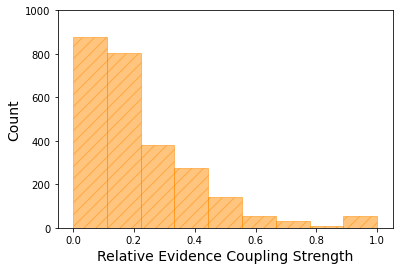

In [20]:
bins = np.linspace(0,1,10)  # fixed number of bins
plt.xlabel('Relative Evidence Coupling Strength',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.ylim([0,1000])
plt.hist(coupling_strength['ratio'], bins=bins, color='darkorange', edgecolor='darkorange', linewidth=1, histtype='bar', alpha=0.5, hatch="//")

In [21]:
threshold_p = 0.3

sufficient_overlap = coupling_strength[coupling_strength['ratio'] > threshold_p]
sufficient_overlap_nodes = list(set(sufficient_overlap['node_1']).union(set(sufficient_overlap['node_2'])))

unique_nodes = list(set(g.vs.indices).difference(set(sufficient_overlap_nodes)))

sufficient_overlap_nodes = g.vs.select(sufficient_overlap_nodes)
unique_nodes = g.vs.select(unique_nodes)

In [22]:
# visualization [any updates need to be here]
sufficient_overlap_nodes['color'] = 'light blue'
unique_nodes['color'] = 'pink'
plot(g, margin=50,bbox=(600,600),layout='kk').show()

In [23]:
# print nodes names
for node in unique_nodes:
    print(node['name'],node['year'],node['outcome'])

Mossner 2001 Positive
Caspi 2003 Positive
Lotrich 2008 Unclear
Kraus 2007 Negative
Comasco_b 2011 Unclear
Wichers 2007 Negative
Uher 2011 Negative
Mitchell 2011 Negative
